In [1]:
# ============================================================
# 0) Setup
# ============================================================
!pip install -q numpy pandas matplotlib scikit-learn tensorflow==2.* ucimlrepo

import os, io, math, zipfile, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

warnings.filterwarnings("ignore")

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("TF:", tf.__version__)


TF: 2.19.0


In [2]:
# ============================================================
# 1) Get data
#    Choose ONE of the two options below
# ============================================================

from google.colab import files

# ---------- Option A: Upload your own CSV ----------
# Requirements:
#  - Must contain either:
#     (a) a single datetime-like column (e.g., 'datetime', 'timestamp', 'DateTime', 'date')
#         and one numeric target column (e.g., 'Global_active_power', 'consumption', 'load')
#     (b) OR separate 'Date' and 'Time' columns.
#  - No need to be hourly; we'll resample.
#
# Uncomment to use:
# uploaded = files.upload()  # browse & upload your CSV
# local_csv_name = list(uploaded.keys())[0]
# df_raw = pd.read_csv(local_csv_name)

# ---------- Option B: Auto-download UCI Household Power dataset ----------
# Official dataset: Individual Household Electric Power Consumption (2+ million rows)
# We'll download, unzip, and load the .txt

!wget -q -O household_power_consumption.zip "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
with zipfile.ZipFile("household_power_consumption.zip","r") as z:
    z.extractall("uci_power")
df_raw = pd.read_csv("uci_power/household_power_consumption.txt", sep=';', na_values=['?'])

print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [16]:
!git clone https://github.com/2310030055/Electricity-Consumption-Forecasting-using-LSTM-and-GRU-.git
%cd Electricity-Consumption-Forecasting-using-LSTM-and-GRU-

Cloning into 'Electricity-Consumption-Forecasting-using-LSTM-and-GRU-'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 14 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 7.23 KiB | 7.23 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/Electricity-Consumption-Forecasting-using-LSTM-and-GRU-


In [17]:
!git config --global user.name "2310030055"
!git config --global user.email "23100300552klh.edu.in"

In [18]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [19]:
# !git add README.md
# !git commit -m "Update README with project details"
!git push origin main

fatal: could not read Username for 'https://github.com': No such device or address


In [20]:
from google.colab import files
files.download("README.md")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# ============================================================
# 2) Parse datetime & choose target column
#    This block handles multiple common schemas automatically.
# ============================================================

def find_datetime(df: pd.DataFrame):
    cols_lower = {c.lower(): c for c in df.columns}
    # Case 1: separate Date + Time
    if 'date' in cols_lower and 'time' in cols_lower:
        dt = pd.to_datetime(
            df[cols_lower['date']] + ' ' + df[cols_lower['time']],
            errors='coerce',
            dayfirst=True  # common in UCI dataset
        )
        return dt

    # Case 2: single datetime-like column candidates
    candidates = ['datetime','timestamp','date','time','date_time','dt']
    for cand in candidates:
        if cand in cols_lower:
            dt = pd.to_datetime(df[cols_lower[cand]], errors='coerce', dayfirst=True)
            if dt.notna().sum() > 0:
                return dt
    # Fallback: try first column that parses reasonably
    for c in df.columns:
        try:
            dt = pd.to_datetime(df[c], errors='coerce', dayfirst=True)
            if dt.notna().sum() > len(df)*0.5:
                return dt
        except:
            pass
    raise ValueError("Could not infer datetime column. Please provide one named like 'Date'+'Time' or 'datetime'.")


def pick_target(df: pd.DataFrame):
    # Try common names
    candidates = ['Global_active_power','global_active_power','consumption','load','power','kwh','energy']
    for c in candidates:
        if c in df.columns:
            if pd.api.types.is_numeric_dtype(df[c]):
                return c
    # Else pick the first numeric column (not the datetime parts)
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols:
        raise ValueError("No numeric target column found. Please ensure your CSV has a numeric consumption column.")
    return num_cols[0]

# Build working DataFrame with datetime + target only
dt = find_datetime(df_raw)
df = df_raw.copy()
df['__datetime__'] = dt
df = df.dropna(subset=['__datetime__']).copy()

TARGET_COL = pick_target(df)
print("Detected target column:", TARGET_COL)

df = df[['__datetime__', TARGET_COL]].rename(columns={'__datetime__':'datetime', TARGET_COL:'y'})
df = df.sort_values('datetime')
df.head()


Detected target column: Global_active_power


,datetime,y
0,2006-12-16 17:24:00,4.216
1,2006-12-16 17:25:00,5.360
2,2006-12-16 17:26:00,5.374
3,2006-12-16 17:27:00,5.388
4,2006-12-16 17:28:00,3.666


In [4]:
# ============================================================
# 3) Resample to hourly & basic cleaning
# ============================================================

# Set index for resampling
df = df.set_index('datetime')

# If data is minutely or irregular, resample to hourly mean
data_hourly = df.resample('H').mean()

# Interpolate small gaps; drop huge gaps if any remain
data_hourly['y'] = data_hourly['y'].interpolate(limit_direction='both')

print("After hourly resample:", data_hourly.shape)
data_hourly.head(10)


After hourly resample: (34589, 1)


,y
datetime,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467
2006-12-16 22:00:00,2.200133
2006-12-16 23:00:00,2.061600
2006-12-17 00:00:00,1.882467
2006-12-17 01:00:00,3.349400


In [5]:
# ============================================================
# 4) Train/Val/Test split (time-based) + Scaling
#    70% train, 15% val, 15% test by default
# ============================================================

def time_split(values: np.ndarray, train=0.7, val=0.15):
    n = len(values)
    n_train = int(n*train)
    n_val = int(n*val)
    n_test = n - n_train - n_val
    return (0, n_train), (n_train, n_train+n_val), (n_train+n_val, n)

values = data_hourly[['y']].values  # shape (N,1)
(train_s, train_e), (val_s, val_e), (test_s, test_e) = time_split(values, 0.7, 0.15)

scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values)

print(f"Splits (idx): train {train_s}:{train_e}, val {val_s}:{val_e}, test {test_s}:{test_e}")
print("Min/Max after scale:", values_scaled.min(), values_scaled.max())


Splits (idx): train 0:24212, val 24212:29400, test 29400:34589
Min/Max after scale: 0.0 0.9999999999999998


In [6]:
# ============================================================
# 5) Make supervised sequences (look_back -> predict horizon=1)
# ============================================================

def make_windows(series_2d, look_back=24, horizon=1, start=0, end=None):
    # series_2d shape: (N,1)
    if end is None:
        end = len(series_2d)
    X, y = [], []
    for i in range(start, end - look_back - horizon + 1):
        X.append(series_2d[i:i+look_back, :])
        y.append(series_2d[i+look_back + horizon - 1, 0])  # next-step target
    X = np.array(X)                    # (samples, look_back, features)
    y = np.array(y).reshape(-1, 1)     # (samples, 1)
    return X, y

LOOK_BACK = 24   # use past 24 hours
HORIZON   = 1    # predict next hour

X_train, y_train = make_windows(values_scaled, LOOK_BACK, HORIZON, train_s, train_e)
X_val,   y_val   = make_windows(values_scaled, LOOK_BACK, HORIZON, val_s, val_e)
X_test,  y_test  = make_windows(values_scaled, LOOK_BACK, HORIZON, test_s, test_e)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)


X_train: (24188, 24, 1) y_train: (24188, 1)
X_val  : (5164, 24, 1) y_val  : (5164, 1)
X_test : (5165, 24, 1) y_test : (5165, 1)


In [7]:
# ============================================================
# 6) Build Models: LSTM & GRU
#    Lightweight, with dropout. You can tune units/stack depth later.
# ============================================================

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

input_shape = (LOOK_BACK, 1)
lstm = build_lstm(input_shape)
gru  = build_gru(input_shape)

lstm.summary(), gru.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

(None, None)

In [8]:
# ============================================================
# 7) Train with callbacks (EarlyStopping, LR Plateaus, Checkpoints)
# ============================================================

os.makedirs("checkpoints", exist_ok=True)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=1),
    ModelCheckpoint("checkpoints/lstm_best.keras", monitor='val_loss', save_best_only=True, verbose=0)
]

history_lstm = lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Switch checkpoint filename for GRU
callbacks_gru = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=1),
    ModelCheckpoint("checkpoints/gru_best.keras", monitor='val_loss', save_best_only=True, verbose=0)
]

history_gru = gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks_gru,
    verbose=1
)


Epoch 1/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.0181 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 2/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 0.0109 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 3/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.0101 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 4/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 0.0096 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 5/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 0.0094 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 6/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 0.0093 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 7/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 0.0092 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 8/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 0.0091 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 9/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.0090 - val_loss: 0.0082 - learning_rate:

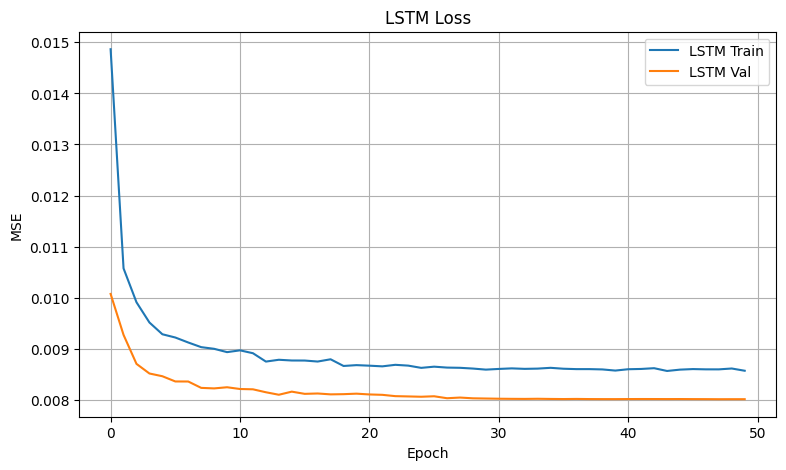

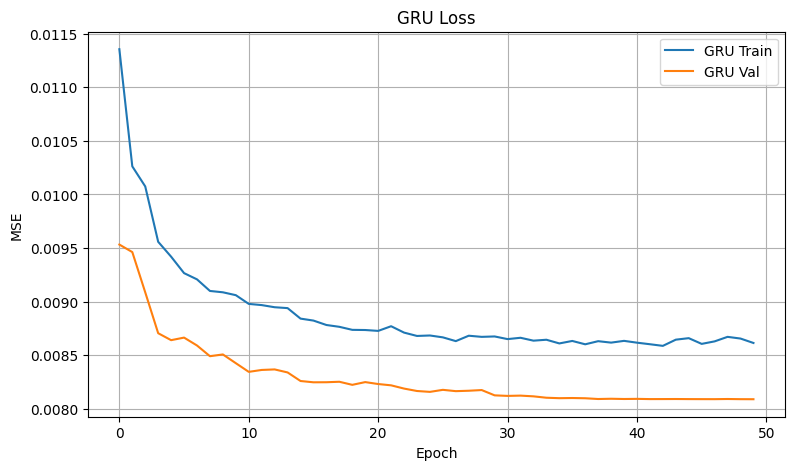

In [9]:
# ============================================================
# 8) Plot training histories
# ============================================================

plt.figure(figsize=(9,5))
plt.plot(history_lstm.history['loss'], label='LSTM Train')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val')
plt.title('LSTM Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(9,5))
plt.plot(history_gru.history['loss'], label='GRU Train')
plt.plot(history_gru.history['val_loss'], label='GRU Val')
plt.title('GRU Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.grid(True)
plt.show()


In [10]:
# ============================================================
# 9) Evaluate on Test set (inverse scale) + metrics
# ============================================================

def evaluate(model, X, y, scaler):
    pred_scaled = model.predict(X, verbose=0)
    y_scaled = y

    pred = scaler.inverse_transform(pred_scaled)
    y_true = scaler.inverse_transform(y_scaled)

    rmse = math.sqrt(mean_squared_error(y_true, pred))
    mae  = mean_absolute_error(y_true, pred)
    mape = np.mean(np.abs((y_true - pred) / (np.maximum(np.abs(y_true), 1e-8)))) * 100.0
    return pred, y_true, {'RMSE': rmse, 'MAE': mae, 'MAPE%': mape}

lstm_pred, y_true, lstm_scores = evaluate(lstm, X_test, y_test, scaler)
gru_pred,  _,      gru_scores  = evaluate(gru,  X_test, y_test, scaler)

print("LSTM:", lstm_scores)
print("GRU :", gru_scores)


LSTM: {'RMSE': 0.48480815467651284, 'MAE': 0.33695126852813323, 'MAPE%': np.float64(46.37136164645825)}
GRU : {'RMSE': 0.48750016093528586, 'MAE': 0.3370854952312886, 'MAPE%': np.float64(45.9942480373976)}


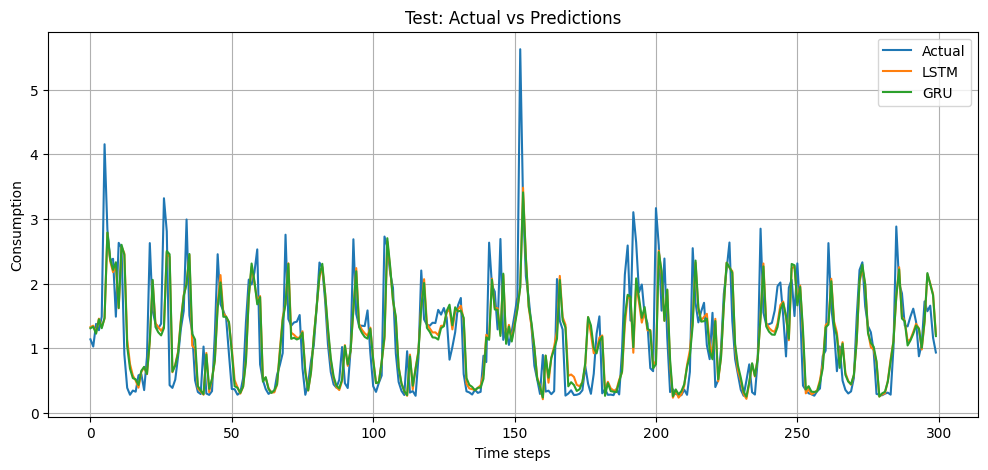

In [11]:
# ============================================================
# 10) Plot Predictions vs Actual (last 300 points for visibility)
# ============================================================

N = min(300, len(y_true))
plt.figure(figsize=(12,5))
plt.plot(y_true[-N:], label='Actual')
plt.plot(lstm_pred[-N:], label='LSTM')
plt.plot(gru_pred[-N:],  label='GRU')
plt.title('Test: Actual vs Predictions')
plt.xlabel('Time steps'); plt.ylabel('Consumption')
plt.legend(); plt.grid(True)
plt.show()


In [12]:
# ============================================================
# 11) Attach timestamps to test predictions
# ============================================================

# Recall X_test/y_test were built from [test_s:test_e] windowed.
# Build index of timestamps for y_test:
test_index = data_hourly.index
# y_test starts at: test_s + LOOK_BACK + HORIZON - 1  (inclusive)
start_idx = test_s + LOOK_BACK + HORIZON - 1
end_idx   = test_e - 1

test_timestamps = test_index[start_idx:end_idx+1]  # align lengths
pred_df = pd.DataFrame({
    'timestamp': test_timestamps,
    'actual': y_true.flatten(),
    'lstm_pred': lstm_pred.flatten(),
    'gru_pred': gru_pred.flatten()
})
pred_df.head(10)


,timestamp,actual,lstm_pred,gru_pred
0,2010-04-25 17:00:00,0.328300,0.625891,0.622351
1,2010-04-25 18:00:00,0.382767,0.497853,0.530322
2,2010-04-25 19:00:00,0.435367,0.557368,0.617672
3,2010-04-25 20:00:00,0.368333,0.675995,0.756635
4,2010-04-25 21:00:00,0.367833,0.840292,0.891799
5,2010-04-25 22:00:00,0.921433,1.050984,1.028941
6,2010-04-25 23:00:00,0.396167,1.497248,1.489912
7,2010-04-26 00:00:00,0.419500,1.034654,1.022605
8,2010-04-26 01:00:00,0.357600,1.046872,1.065474
9,2010-04-26 02:00:00,0.352500,0.793174,0.711235


In [13]:
# ============================================================
# 12) Forecast the next 24 hours (recursive)
# ============================================================

def forecast_next_n(model, series_scaled, n_steps, look_back=24, scaler=None):
    """
    series_scaled: (N,1) scaled full series up to "now"
    n_steps: steps to forecast ahead, recursive 1-step
    """
    window = series_scaled[-look_back:].copy()  # (look_back,1)
    outs = []
    for _ in range(n_steps):
        inp = window.reshape(1, look_back, 1)
        out_scaled = model.predict(inp, verbose=0)
        outs.append(out_scaled[0,0])
        # slide window
        window = np.vstack([window[1:], out_scaled])
    outs = np.array(outs).reshape(-1,1)
    if scaler is not None:
        outs = scaler.inverse_transform(outs)
    return outs

NEXT_HOURS = 24
future_lstm = forecast_next_n(lstm, values_scaled, NEXT_HOURS, LOOK_BACK, scaler)
future_gru  = forecast_next_n(gru,  values_scaled, NEXT_HOURS, LOOK_BACK, scaler)

last_ts = data_hourly.index[-1]
future_index = pd.date_range(last_ts + pd.Timedelta(hours=1), periods=NEXT_HOURS, freq='H')

future_df = pd.DataFrame({
    'timestamp': future_index,
    'lstm_forecast': future_lstm.flatten(),
    'gru_forecast':  future_gru.flatten()
})
future_df.head(10)


,timestamp,lstm_forecast,gru_forecast
0,2010-11-26 22:00:00,0.946380,0.943180
1,2010-11-26 23:00:00,0.847596,0.882620
2,2010-11-27 00:00:00,0.689194,0.789427
3,2010-11-27 01:00:00,0.580501,0.714670
4,2010-11-27 02:00:00,0.525038,0.675091
5,2010-11-27 03:00:00,0.530773,0.685105
6,2010-11-27 04:00:00,0.623793,0.767502
7,2010-11-27 05:00:00,0.838660,0.959271
8,2010-11-27 06:00:00,1.173408,1.265803
9,2010-11-27 07:00:00,1.475104,1.538857


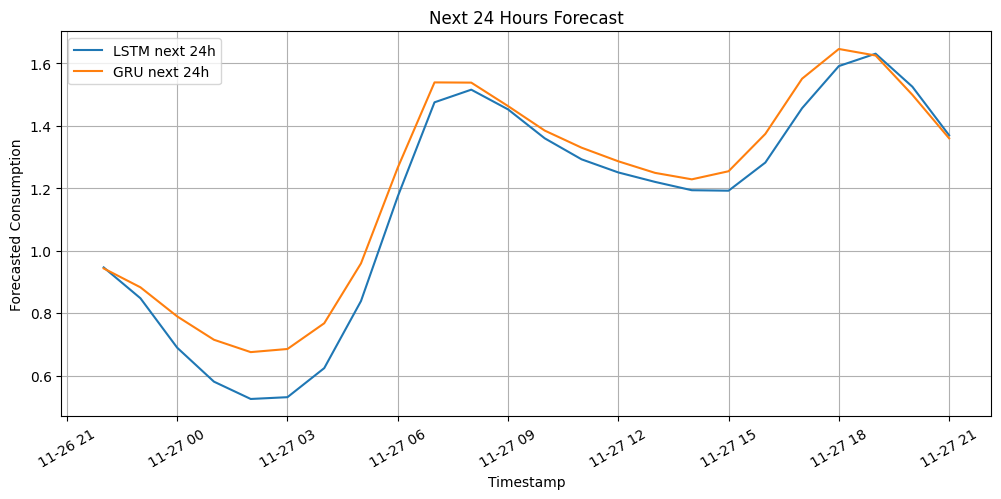

In [14]:
# ============================================================
# 13) Plot next-24-hour forecast
# ============================================================

plt.figure(figsize=(12,5))
plt.plot(future_df['timestamp'], future_df['lstm_forecast'], label='LSTM next 24h')
plt.plot(future_df['timestamp'], future_df['gru_forecast'],  label='GRU next 24h')
plt.title('Next 24 Hours Forecast')
plt.xlabel('Timestamp'); plt.ylabel('Forecasted Consumption')
plt.legend(); plt.grid(True)
plt.xticks(rotation=30)
plt.show()


In [15]:
# ============================================================
# 14) Save artifacts (optional)
# ============================================================

os.makedirs("artifacts", exist_ok=True)
lstm.save("artifacts/lstm_model.keras")
gru.save("artifacts/gru_model.keras")
pred_df.to_csv("artifacts/test_predictions.csv", index=False)
future_df.to_csv("artifacts/next24_forecast.csv", index=False)

print("Saved to 'artifacts/' folder:")
print(os.listdir("artifacts"))


Saved to 'artifacts/' folder:
['gru_model.keras', 'lstm_model.keras', 'next24_forecast.csv', 'test_predictions.csv']
